In [1]:
from coffea.nanoevents import NanoEventsFactory, BaseSchema, PFNanoAODSchema
import json
import fastjet
import numpy as np
import awkward as ak
from coffea import processor
import hist
import coffea.nanoevents.methods.vector as vector
import warnings
import hist.dask as dhist
import dask
import pickle
from coffea.ml_tools.torch_wrapper import torch_wrapper
import pandas as pd

/tmp/ipykernel_1734044/18261434.py:8: FutureWarning: In version 2024.7.0 (target date: 2024-06-30 11:59:59-05:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  import coffea.nanoevents.methods.vector as vector


In [2]:
warnings.filterwarnings("ignore", "Found duplicate branch")
warnings.filterwarnings("ignore", "Missing cross-reference index for")
warnings.filterwarnings("ignore", "dcut")
warnings.filterwarnings("ignore", "Please ensure")
warnings.filterwarnings("ignore", "The necessary")
warnings.filterwarnings("ignore",  module="coffea.*")

with open("../data_dv4.pkl", "rb") as fr:
    datasets = pickle.load(fr)

In [3]:
temp = {}
temp['hgg'] = datasets['hgg']
temp['q476'] = datasets['q476']
datasets = temp

In [4]:
source = "/project01/ndcms/cmoore24"
events = {}
for name, info in datasets.items():
    events[name] = NanoEventsFactory.from_root(
        {f"{source}/{info['path']}/{fn}": "/Events" for fn in info["files"]},
        schemaclass=PFNanoAODSchema,
        # uproot_options={"chunks_per_file":1},
        metadata={"dataset": info["label"]},
    ).events()

In [5]:
hgg = ak.from_parquet('/scratch365/cmoore24/training/data/hgg.parquet')
hbb = ak.from_parquet('/scratch365/cmoore24/training/data/hbb.parquet')

pick = hgg
title = 'hgg'
#pick = hbb
#title = 'hbb'

pick = pick[pick['FatJets.msoftdrop'] < 140]
pick = pick[pick['FatJets.pt'] < 600]
pick = pick[pick['FatJets.pt'] > 450]
pick['FatJets.mratio'] = pick['FatJets.mass']/pick['FatJets.msoftdrop']

In [6]:
background = ak.from_parquet('/scratch365/cmoore24/training/data/qcd.parquet')
background = background[background['FatJets.msoftdrop'] < 140]
background = background[background['FatJets.pt'] < 600]
background = background[background['FatJets.pt'] > 450]
background['FatJets.mratio'] = background['FatJets.mass']/background['FatJets.msoftdrop']

In [7]:
with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

/afs/crc.nd.edu/user/c/cmoore24/miniconda3/envs/coffea2024/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.2.0 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [8]:
bkg_msd = background['FatJets.msoftdrop']

In [13]:
class ParticleNetExample1(torch_wrapper):
    def prepare_awkward(self, events, scaler):
        fatjets = events

        imap = {
            'vars': {
                'n2b1': fatjets['FatJets.n2b1'],
                'n3b1': fatjets['FatJets.n3b1'],
                'nConstituents': fatjets['FatJets.nConstituents'],
                'color_ring': fatjets['FatJets.color_ring'],
                'd2b1': fatjets['FatJets.d2b1'],
                'u1': fatjets['FatJets.u1'],
                'u2': fatjets['FatJets.u2'],
                'u3': fatjets['FatJets.u3'],
                'm2': fatjets['FatJets.m2'],
                'm3': fatjets['FatJets.m3'],
                'n4': fatjets['FatJets.n4'],
                #'mratio': fatjets['FatJets.mratio'],
            },
        }

        retmap = {
            k: ak.concatenate([x[:, np.newaxis] for x in imap[k].values()], axis=1)
            for k in imap.keys()
        }
        x = ak.values_astype(scaler.transform(retmap['vars']), "float32")
        return (x,), {}

In [14]:
a = ParticleNetExample1('hgg_traced_model.pt')

In [15]:
b = a(background, scaler)[:,0]

In [16]:
b

<Array [-4.45, -2.54, 4.62, ..., -19.1, -5.27, -15.4] type='459151 * float32'>

In [20]:
qcd_msd = bkg_msd[b > 0]

In [21]:
import matplotlib.pyplot as plt

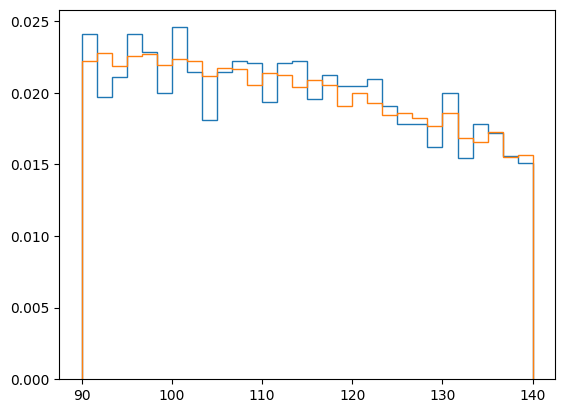

In [23]:
fig, ax = plt.subplots()
plt.hist(qcd_msd, range=(90,140), bins=30, density=True, histtype='step', label='Cut QCD')
plt.hist(bkg_msd, range=(90,140), bins=30, density=True, histtype='step', label='QCD')
plt.show()